In [1]:
import drdf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def load_drdf(fname):
  reader = drdf.DRDF()
  reader.read(fname)
  events = []
  for run in reader.runs:
    for event in reader.runs[run]:
      hits_map = dict()
      for cam, img in reader.runs[run][event].items():
        amplitude = img.pixels[:, :, 0] 
        time = img.pixels[:, :, 1]
        hits_map[cam] = amplitude
      events.append((event, hits_map))
  return events

In [3]:
file_drdf_list = ["/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/good_data_last1/response.drdf", "/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/good_data_last2/response.drdf"]
file_root_list = ["/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/good_data_last1/sensors.root", "/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/good_data_last2/sensors.root"]

In [4]:
def CamList(fname):
    cam_list = []
    file = load_drdf(fname)
    for cam in file[0][1]:
        cam_list.append(cam)
    return cam_list

In [5]:
#creo una matrice 1000 righe x 54 colonne. ogni elemento è una camera 31x31
def AllImages(fname): 
    all_images_list = []
    cam_list = CamList(fname)
    file = load_drdf(fname)
    for i in range(len(file)):
        ph_matrix = []
        for cam in cam_list:
            ph_matrix.append(file[i][1][cam])
        all_images_list.append(ph_matrix)
    all_images = np.array(all_images_list)
    return all_images

In [6]:
def DimensionsData(fname):
    all_images = AllImages(fname)
    cam_list = CamList(fname)
    nr_events = len(all_images)
    nr_pixels = len(all_images[0][0])
    nr_cams = len(cam_list)
    nr_tot_events = nr_cams*nr_events
    nr_pixels_1_ev = nr_pixels*nr_pixels*nr_cams
    return nr_events, nr_pixels, nr_cams, nr_tot_events, nr_pixels_1_ev

In [7]:
#creo una matrice di 1000 righe e 51894 colonne. Così per ogni evento, la riga corrispondente presenta tutti i pixel di tutte le camere
def PixelsAllCamsPerEvents(fname):
    all_images = AllImages(fname)
    nr_events, nr_pixels, nr_cams, nr_tot_events, nr_pixels_1_ev = DimensionsData(fname)
    pixels_to_scale = []
    for images_all_cams_per_ev in all_images: 
        pixels_all_cams_per_ev = images_all_cams_per_ev.flatten()
        pixels_to_scale.append(pixels_all_cams_per_ev)
    pixels_to_scale = np.asarray(pixels_to_scale)
    pixels_to_scale_matrix = pixels_to_scale.reshape(nr_events,nr_pixels_1_ev,1)
    return pixels_to_scale_matrix

In [8]:
def PlotCamsImages(fname):
    all_images = AllImages(fname)
    file = load_drdf(fname)
    cam_list = CamList(fname)
    for i in range(len(all_images)):
        #for cam in cam_list:
        for j in range(len(all_images[i])):
            plt.imshow(all_images[i][j], interpolation='none')
            plt.colorbar()
            plt.title(f"event {file[i][0]} on {cam_list[j]}")
            plt.show()
            break
        break

SCALING DATA

In [9]:
from sklearn.preprocessing import RobustScaler

def findMax(fname):
    all_images = AllImages(fname)
    all_max = []
    for i in range(len(all_images)):
        max_ev = np.max(all_images[i])
        all_max.append(max_ev)
    return all_max

def Normalizing(fname):
    all_max = findMax(fname)
    all_normalized_data = []
    nr_events, nr_pixels, nr_cams, nr_tot_events, nr_pixels_1_ev = DimensionsData(fname)
    pixels_to_scale_matrix = PixelsAllCamsPerEvents(fname)
    for i in range(len(pixels_to_scale_matrix)):
        norm_data = []
        for j in range(len(pixels_to_scale_matrix[i])):
            if all_max[i] != 0: 
                norm = pixels_to_scale_matrix[i][j]/all_max[i]
            norm_data.append(norm)
        all_normalized_data.append(norm_data)
    all_normalized_data_matrix = np.asarray(all_normalized_data)
    all_normalized_data = all_normalized_data_matrix.reshape(nr_events,nr_cams,nr_pixels,nr_pixels)
    return all_normalized_data

In [11]:
#ora ho una matrice 1000righex54colonne dove un elemento è una matrice 31x31. Per essere consistente con i dati di root la voglio trasformare in un array di 54000 elementi
def Flattening(fname):
    all_images_scaled = Normalizing(fname)
    all_images_scaled_1d = []
    for sublist in all_images_scaled:
        all_images_scaled_1d.extend(sublist)
    return all_images_scaled_1d

In [12]:
def Reshaping(fname):
    all_images_scaled_1d_reshaped = []
    all_images = AllImages(fname)
    all_images_scaled_1d = Flattening(fname)
    nr_events, nr_pixels, nr_cams, nr_tot_events, nr_pixels_1_ev = DimensionsData(fname)
    for data in all_images_scaled_1d:
        data_new = data.reshape(nr_pixels,nr_pixels,1)
        all_images_scaled_1d_reshaped.append(data_new)
    return all_images_scaled_1d_reshaped

In [13]:
def PlotCamsImages(fname):
    all_images_scaled = Normalizing(fname)
    file = load_drdf(fname)
    cam_list = CamList(fname)
    for i in range(len(all_images_scaled)):
        for j in range(len(all_images_scaled[i])):
            plt.imshow(all_images_scaled[i][j], interpolation='none')
            plt.colorbar()
            plt.title(f"event {file[i][0]} on {cam_list[j]}")
            plt.show()
            break
        break

#PlotCamsImages()

In [14]:
def PreprocessWithScaling(fname):
    return Reshaping(fname)

In [ ]:
def PreprocessNotScaled(fname):
    matrix = AllImages(fname)
    nr_events, nr_pixels, nr_cams, nr_tot_events, nr_pixels_1_ev = DimensionsData(fname)
    array = matrix.reshape(nr_events*nr_cams, nr_pixels, nr_pixels)
    return array

In [ ]:
def SumPhotons(fname):
    tot_photons = []
    all_images = PreprocessNotScaled(fname)
    for j in all_images:
        sum_ph = np.sum(j)
        tot_photons.append(sum_ph)
    return tot_photons

ROOT

In [15]:
import ROOT as root

def OpenRootFile(rname,fname):
    #sensor1.root è il file; ogni camera è un TTree
    input_file = root.TFile.Open(rname, "READ")
    #tree = input_file.Get("CAM_NB_X2")

    cam_list = CamList(fname)

    nr_photons_list_all_cams_list = []
    for cam in cam_list:
        nr_photons_list = []
        tree = input_file.Get(cam)
        entries = tree.GetEntries()
        for i in range(entries):
            n = tree.GetEntry(i)
            inner_photons = tree.innerPhotons
            nr_photons_list.append(inner_photons)
        nr_photons_list_all_cams_list.append(nr_photons_list)
        nr_photons_list_all_cams = np.array(nr_photons_list_all_cams_list)#ho creato una matrice 1000 colonne (nr eventi) x 54 righe (nr camere). I numeri che vediamo sono i numeri di fotoni che arrivano alla camera
    return nr_photons_list_all_cams

#nr_photons_list_all_cams = np.array(nr_photons_list_all_cams_list)#ho creato una matrice 1000 colonne (nr eventi) x 54 righe (nr camere). I numeri che vediamo sono i numeri di fotoni che arrivano alla camera


Welcome to JupyROOT 6.28/04


In [16]:
def EventListNumber(fname):
    file = load_drdf(fname)
    ev_list = []
    for i in range(len(file)):
        ev_list.append(file[i][0])
    return ev_list

In [17]:
def column(matrix, i):
    column = [row[i] for row in matrix]
    return column

def RootDataDictionary(rname,fname):
    nr_photons_list_all_cams = OpenRootFile(rname,fname)
    ev_list = EventListNumber(fname)
    all_photons_in_ev = []
    for i in ev_list:
        nr_photons_in_ev = column(nr_photons_list_all_cams, i)#lista di fotoni in un determinato evento/sono le colonne delle matrici
        all_photons_in_ev.append(nr_photons_in_ev)#faccio una lista di queste liste di fotoni

    cam_list = CamList(fname)

    final_root_data = []
    for i in range(len(all_photons_in_ev)):
        nr_photon_in_cam = []
        for j in range(len(all_photons_in_ev[i])):
            nr_photon_in_cam.append(all_photons_in_ev[i][j])
        dict_cam_ev = dict(zip(cam_list, nr_photon_in_cam))
        final_root_data.append((ev_list[i], dict_cam_ev))
    return final_root_data

In [ ]:
def InitializeDatasetParameters():
    ratio_thr = 0.1
    sum_thr = 40
    perc_val = 0.2
    perc_train = 0.9
    return ratio_thr, sum_thr, perc_val, perc_train

ratio_thr, sum_thr, perc_val, perc_train = InitializeDatasetParameters()

In [18]:
def InnerPhotonsList(rname,fname):
    final_root_data = RootDataDictionary(rname, fname)
    inner_photons_list = []
    for i in range(len(final_root_data)):
        for cam in final_root_data[i][1].keys():
            inner_photons_list.append(final_root_data[i][1][cam])  
    inner_photons_list = np.asarray(inner_photons_list)
    return inner_photons_list

def CamStatesRootList(rname,fname):
    inner_photons_list = InnerPhotonsList(rname,fname)
    tot_photons = SumPhotons(fname)
    
    ev_cam_state = []
    for i in range(len(inner_photons_list)):
        np.seterr(divide='ignore', invalid='ignore')
        ratio = inner_photons_list[i]/tot_photons[i]
        if ratio >= ratio_thr:
            value = 1#acc
        elif ratio < ratio_thr:
            value = 0#non acc
        ev_cam_state.append(value)
    return ev_cam_state

In [19]:
def RootPreprocessing(rname, fname):
    return CamStatesRootList(rname, fname)

add other data

In [20]:
# all_images_scaled_1d = Preprocessing(file_drdf_list[0])
# ev_cam_state = RootPreprocessing(file_root_list[0],file_drdf_list[0])
# #inner_photons_list = InnerPhotonsList("/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/initial_data/sensors.root","/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/data/initial_data/response.drdf")

In [21]:
# #57 eventi e 58 camere, 32x32 pixels
# data_prep2 = Preprocessing(file_drdf_list[1])
# ev_cam_state2 = RootPreprocessing(file_root_list[1], file_drdf_list[1])

In [22]:
# #57 eventi e 60 camere, 32x32 pixels 
# # data_prep3 = Preprocessing(file_drdf_list[2])
# ev_cam_state3 = RootPreprocessing(file_root_list[2],file_drdf_list[2])

In [23]:
# #57 eventi e 60 camere, 32x32 pixels 
# data_prep4 = Preprocessing(file_drdf_list[3])
# ev_cam_state4 = RootPreprocessing(file_root_list[3],file_drdf_list[3])

CNN MODEL

In [24]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from sklearn.model_selection import train_test_split

In [ ]:
def Cut(rname: list, fname: list):
    all_images = np.concatenate([PreprocessNotScaled(i) for i in fname]) 
    root_images = np.concatenate([RootPreprocessing(rname[i],fname[i]) for i in range(len(fname))]) 
    inner_photons = np.concatenate([InnerPhotonsList(rname[i], fname[i]) for i in range(len(fname))])

    index_to_cut = []
    i = 0
    for image in all_images:
        if np.sum(image)<sum_thr:
            index_to_cut.append(i)
        i += 1
    return index_to_cut, all_images, root_images, inner_photons#, all_images_scaled

In [ ]:
def DatasetCut(rname: list, fname: list):
    index_to_cut, all_images, root_images, inner_photons = Cut(rname, fname)
    all_images_list = list(all_images)
    root_images_list = list(root_images)
    inner_photons_list = list(inner_photons)
    #all_images_scaled_list = list(all_images_scaled)
    
    for i in sorted(index_to_cut, reverse=True):
        del all_images_list[i], root_images_list[i], inner_photons_list[i]#, all_images_scaled_list[i]

    data_cut = np.array(all_images_list)
    root_cut = np.array(root_images_list)
    inner_photons_cut = np.array(inner_photons_list)
    #data_scaled_cut = np.array(all_images_scaled_list)

    data_cut = data_cut.reshape(data_cut.shape[0],32,32,1)
    #data_scaled_cut = data_scaled_cut.reshape(data_scaled_cut.shape[0],32,32,1)

    return data_cut, root_cut, inner_photons_cut#, data_scaled_cut

In [ ]:
def PrepareData(rname: list, fname: list):
    data_cut, root_cut, inner_photons_cut = DatasetCut(rname, fname)
    t_ds, val_ds, t_labels, val_labels = train_test_split(data_cut, root_cut, train_size=0.87, random_state=42)
    train_ds, test_ds, train_labels, test_labels = train_test_split(t_ds, t_labels, train_size=0.9, random_state=42)

    train_ds = np.asarray(train_ds)
    val_ds = np.asarray(val_ds)
    test_ds = np.asarray(test_ds)

    train_ds = train_ds.reshape(train_ds.shape[0], 32, 32,1)
    val_ds = val_ds.reshape(val_ds.shape[0], 32, 32, 1)
    test_ds = test_ds.reshape(test_ds.shape[0],32,32,1)

    return train_ds, val_ds, test_ds, train_labels, val_labels, test_labels

In [25]:
def SplitDataset(rname,fname):
    all_images_scaled_1d = Flattening(fname)
    inner_photons_list = InnerPhotonsList(rname,fname)
    #ev_cam_state = rooprep.CamStatesRootList(rname, fname)
    t_ds, val_ds, t_inner_ph, val_inner_ph = train_test_split(all_images_scaled_1d, inner_photons_list, train_size=0.9, random_state=42)
    train_ds, test_ds, train_inner_ph, test_inner_ph = train_test_split(t_ds, t_inner_ph, train_size=0.9, random_state=42)

    train_ds = np.asarray(train_ds)
    val_ds = np.asarray(val_ds)
    train_inner_ph = np.asarray(train_inner_ph) 
    val_inner_ph = np.asarray(val_inner_ph)
    test_ds = np.asarray(test_ds) 
    test_inner_ph = np.asarray(test_inner_ph)

    return train_ds, val_ds, test_ds, train_inner_ph, val_inner_ph, test_inner_ph


In [26]:
def PrepareDataSingleFile(rname, fname):
    train_ds, val_ds, test_ds, train_inner_ph, val_inner_ph, test_inner_ph = SplitDataset(rname,fname)
    nr_events, nr_pixels, nr_cams, nr_tot_events, nr_pixels_1_ev = DimensionsData(fname)

    train_labels_bool = train_inner_ph > 5
    train_labels = train_labels_bool.astype(int)

    val_labels_bool = val_inner_ph > 5
    val_labels = val_labels_bool.astype(int)

    test_labels_bool = test_inner_ph > 5
    test_labels = test_labels_bool.astype(int)

    train_ds = train_ds.reshape(train_ds.shape[0], nr_pixels,nr_pixels, 1)
    val_ds = val_ds.reshape(val_ds.shape[0], nr_pixels, nr_pixels, 1)
    test_ds = test_ds.reshape(test_ds.shape[0],nr_pixels,nr_pixels,1)
    return train_ds, val_ds, test_ds, train_labels, val_labels, test_labels

In [27]:
# #dataset1
# train_ds1, val_ds1, test_ds1, train_labels1, val_labels1, test_labels1 = PrepareDataSingleFile(file_root_list[0],file_drdf_list[0])

In [28]:
# #dataset2
# train_ds2, val_ds2, test_ds2, train_labels2, val_labels2, test_labels2 = PrepareDataSingleFile(file_root_list[1],file_drdf_list[1])

In [29]:
# #dataset3
# train_ds3, val_ds3, test_ds3, train_labels3, val_labels3, test_labels3 = PrepareDataSingleFile(file_root_list[2],file_drdf_list[2])

In [30]:
def WholeDataset(rname: list,fname: list):
    #dataset1
    train_ds1, val_ds1, test_ds1, train_labels1, val_labels1, test_labels1 = PrepareDataSingleFile(rname[0],fname[0])
    #dataset2
    train_ds2, val_ds2, test_ds2, train_labels2, val_labels2, test_labels2 = PrepareDataSingleFile(rname[1],fname[1])
    #dataset3
    train_ds3, val_ds3, test_ds3, train_labels3, val_labels3, test_labels3 = PrepareDataSingleFile(rname[2],fname[2])
    #dataset4
    train_ds4, val_ds4, test_ds4, train_labels4, val_labels4, test_labels4 = PrepareDataSingleFile(rname[3],fname[3])

    train_ds = np.concatenate((train_ds1, train_ds2, train_ds3,train_ds4), axis=0)
    val_ds = np.concatenate((val_ds1, val_ds2, val_ds3,val_ds4), axis=0)
    test_ds = np.concatenate((test_ds1, test_ds2, test_ds3,test_ds4), axis=0)

    train_labels = np.concatenate((train_labels1, train_labels2, train_labels3, train_labels4), axis=0)
    val_labels = np.concatenate((val_labels1, val_labels2, val_labels3, val_labels4), axis=0)
    test_labels = np.concatenate((test_labels1, test_labels2, test_labels3, test_labels4), axis=0)
    return train_ds, val_ds, test_ds,train_labels, val_labels,test_labels

In [31]:
def FindBlindEvents(rname,fname):
    ev_cam_state = RootPreprocessing(rname,fname)
    data_prep = Preprocessing(fname)
    n = 0
    nr_blind_events = []
    blind_events = []
    for i in ev_cam_state:
        if i == 1:
            nr_blind_events.append(n)
        n+=1
    for i in nr_blind_events:
        #if np.max(i)>100:
        blind_events.append(data_prep[i])
    return nr_blind_events, blind_events

In [48]:
ev_cam_state = RootPreprocessing(file_root_list[0], file_drdf_list[0])

In [50]:
prova = FindBlindEvents(file_root_list[0], file_drdf_list[0])

In [32]:
# nr_blind_events1, blind_events1 = FindBlindEvents(file_root_list[0],file_drdf_list[0])
# nr_blind_events2, blind_events2 = FindBlindEvents(file_root_list[1],file_drdf_list[1])
# nr_blind_events3, blind_events3 = FindBlindEvents(file_root_list[2],file_drdf_list[2])

In [33]:
def Augmentation(rname: list, fname: list):
    input_shape = [32,32,32,1]
    data_augmentation = keras.Sequential()
    data_augmentation.add(layers.RandomFlip("horizontal", input_shape=input_shape[1:]))
    data_augmentation.add(layers.RandomRotation(0.2))
    data_augmentation.add(layers.RandomTranslation(0.2,0.2))
    
    nr_blind_events1, blind_events1 = FindBlindEvents(rname[0], fname[0])
    nr_blind_events2, blind_events2 = FindBlindEvents(rname[1], fname[1])
    nr_blind_events3, blind_events3 = FindBlindEvents(rname[2], fname[2])
    nr_blind_events14, blind_events4 = FindBlindEvents(rname[3], fname[3])
    
    all_blind_events = np.concatenate((blind_events1,blind_events2,blind_events3,blind_events4), axis=0)

    augmented_ds = []
    for blind_im in all_blind_events:
        for i in range(9):
            augmented_image = data_augmentation(blind_im)
            augmented_image_sq = np.squeeze(augmented_image, axis=3)
            augmented_ds.append(augmented_image_sq)
    augmented_ds = np.asarray(augmented_ds)

    augmented_labels = len(augmented_ds)*[1]
    return augmented_ds, augmented_labels

In [34]:
def DatasetwithAugmentation(rname: list, fname: list):
    train_ds, val_ds, test_ds,train_labels, val_labels,test_labels = WholeDataset(rname, fname)
    augmented_ds, augmented_labels = Augmentation(rname, fname)
    train_ds_aug = np.concatenate((train_ds,augmented_ds),axis=0)
    train_labels_aug = np.concatenate((train_labels,augmented_labels),axis=0)
    return train_ds_aug, train_labels_aug

In [35]:
def DatasetWeights(rname: list, fname: list):
    nr_blind_events1, blind_events1 = FindBlindEvents(rname[0],fname[0])
    nr_blind_events2, blind_events2 = FindBlindEvents(rname[1],fname[1])
    nr_blind_events3, blind_events3 = FindBlindEvents(rname[2],fname[2])
    nr_blind_events4, blind_events4 = FindBlindEvents(rname[3], fname[3])

    nr_events1, nr_pixels1, nr_cams1, nr_tot_events1, nr_pixels_1_ev1 = DimensionsData(fname[0])
    nr_events2, nr_pixels2, nr_cams2, nr_tot_events2, nr_pixels_1_ev2 = DimensionsData(fname[1])
    nr_events3, nr_pixels3, nr_cams3, nr_tot_events3, nr_pixels_1_ev3 = DimensionsData(fname[2])
    nr_events4, nr_pixels4, nr_cams4, nr_tot_events4, nr_pixels_1_ev4 = DimensionsData(fname[3])

    augmented_ds, augmented_labels = Augmentation(rname, fname)
    
    nr_blind_ev = len(nr_blind_events1) + len(nr_blind_events2) + len(nr_blind_events3) + len(nr_blind_events4) + len(augmented_ds)
    nr_tot_ev = nr_tot_events1 + nr_tot_events2 + nr_tot_events3 + nr_tot_events4 + len(augmented_ds)
    nr_not_blind_ev = nr_tot_ev - nr_blind_ev

    initial_bias = np.log(nr_blind_ev/nr_not_blind_ev)

    weights_0 = (1/nr_not_blind_ev)*(nr_tot_ev/2)
    weights_1 = (1/nr_blind_ev)*(nr_tot_ev/2)
    weights_classes = {0: weights_0, 1: weights_1}
    return initial_bias, weights_classes

In [36]:
def Training(rname: list, fname: list): 
    #initial_bias, weights_classes = DatasetWeights(rname,fname)
    input_shape = [32,32,32,1]
    #output_bias = keras.initializers.Constant(initial_bias)
    model = models.Sequential()
    #model.add(data_augmentation)
    model.add(layers.Conv2D(8,3,padding='same', activation='ReLU', input_shape=input_shape[1:]))
    model.add(layers.Conv2D(16,3,padding='same', activation='ReLU', input_shape=input_shape[1:]))
    model.add(layers.Conv2D(16,3,padding='same', activation='ReLU', input_shape=input_shape[1:]))
    #model.add(layers.Conv2D(32,3,padding='same', activation='sigmoid', input_shape=input_shape[1:]))
    model.add(layers.MaxPooling2D((32,32)))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))#, bias_initializer=output_bias))

    model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
    model.summary()
    return model


In [37]:
model = Training(file_root_list, file_drdf_list)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 8)         80        
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        1168      
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 1, 1, 16)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                        

In [38]:
train_ds, val_ds, test_ds,train_labels, val_labels,test_labels = WholeDataset(file_root_list, file_drdf_list)

In [39]:
#train_ds_aug, train_labels_aug = DatasetwithAugmentation(file_root_list,file_drdf_list)

In [40]:
initial_bias, weights_classes = DatasetWeights(file_root_list, file_drdf_list)
epochs = 10

In [41]:
#callbacks = [keras.callbacks.ModelCheckpoint("/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/ultima_versione_buoni/tf_model_new/cams_model_new.keras")]
history = model.fit(train_ds, train_labels, validation_data= (val_ds, val_labels), epochs=epochs, batch_size=32)# class_weight=weights_classes)

Epoch 1/10
3158/3158 [==============================] - 34s 11ms/step - loss: 0.0383 - accuracy: 0.9948 - val_loss: 0.0307 - val_accuracy: 0.9951
Epoch 2/10
3158/3158 [==============================] - 34s 11ms/step - loss: 0.0311 - accuracy: 0.9948 - val_loss: 0.0281 - val_accuracy: 0.9951
Epoch 3/10
3158/3158 [==============================] - 33s 11ms/step - loss: 0.0295 - accuracy: 0.9948 - val_loss: 0.0233 - val_accuracy: 0.9951
Epoch 4/10
3158/3158 [==============================] - 32s 10ms/step - loss: 0.0207 - accuracy: 0.9960 - val_loss: 0.0202 - val_accuracy: 0.9966
Epoch 5/10
3158/3158 [==============================] - 34s 11ms/step - loss: 0.0193 - accuracy: 0.9964 - val_loss: 0.0202 - val_accuracy: 0.9966
Epoch 6/10
3158/3158 [==============================] - 33s 11ms/step - loss: 0.0185 - accuracy: 0.9966 - val_loss: 0.0185 - val_accuracy: 0.9966
Epoch 7/10
3158/3158 [==============================] - 33s 10ms/step - loss: 0.0179 - accuracy: 0.9966 - val_loss: 0.0180 -

In [42]:
# train_ds, val_ds, test_ds,train_labels, val_labels,test_labels = WholeDataset(file_root_list, file_drdf_list)
# results = model.evaluate(test_ds,test_labels)

In [43]:
predictions_train = model.predict(train_ds)
predictions = np.squeeze(predictions_train)

i = 0
predictions_train_approx = []
for value in predictions:
    value_approx = int(round(value,0))
    predictions_train_approx.append(value_approx)

predictions_train_approx = np.asarray(predictions_train_approx)

3158/3158 [==============================] - 9s 3ms/step


[[100492     14]
 [   302    219]]


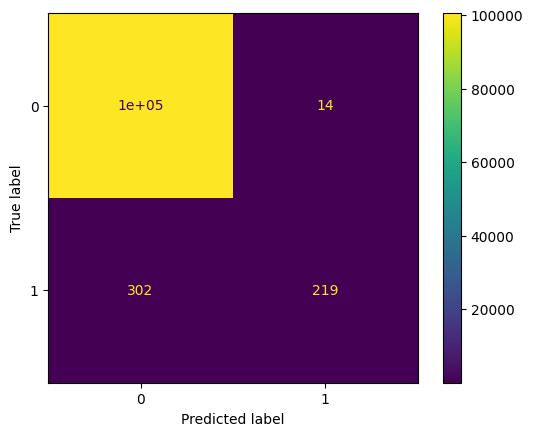

In [45]:
from sklearn import metrics

cm = metrics.confusion_matrix(train_labels, predictions_train_approx)
print(cm)
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

In [46]:
saved_model = model.save("/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/ultima_versione_buoni/tf_model_new/cams_model_normalization.keras")

In [ ]:
mismatch_list = []
for i in range(len(train_ds_aug)):
    #if test_labels[i] == 1 and predictions_approx[i] == 0:
    if train_labels_aug[i] != predictions_train_approx[i]:
        mismatch_list.append(i)

fn_list = []
for i in range(len(train_ds_aug)):
    if train_labels_aug[i] == 1 and predictions_train_approx[i] == 0:
        fn_list.append(i)

fp_list = []
for i in range(len(train_ds_aug)):
    if train_labels_aug[i] == 0 and predictions_train_approx[i] == 1:
        fp_list.append(i)

Altering true data

In [ ]:
import copy

fn_list = np.asarray(fn_list)
fn_list_split = fn_list[:168]
#fn_list_split = np.split(fn_list,3)

train_labels_aug2 = copy.deepcopy(train_labels_aug)
for i in fn_list_split:
    train_labels_aug2[i] = 0

In [ ]:
def DatasetWeights(rname: list, fname: list):
    nr_blind_events1, blind_events1 = FindBlindEvents(rname[0],fname[0])
    nr_blind_events2, blind_events2 = FindBlindEvents(rname[1],fname[1])
    nr_blind_events3, blind_events3 = FindBlindEvents(rname[2],fname[2])

    nr_events1, nr_pixels1, nr_cams1, nr_tot_events1, nr_pixels_1_ev1 = DimensionsData(fname[0])
    nr_events2, nr_pixels2, nr_cams2, nr_tot_events2, nr_pixels_1_ev2 = DimensionsData(fname[1])
    nr_events3, nr_pixels3, nr_cams3, nr_tot_events3, nr_pixels_1_ev3 = DimensionsData(fname[2])

    augmented_ds, augmented_labels = Augmentation(rname, fname)
    
    nr_blind_ev = len(nr_blind_events1) + len(nr_blind_events2) + len(nr_blind_events3) + len(fn_list_split) + len(augmented_ds)
    nr_tot_ev = nr_tot_events1 + nr_tot_events2 + nr_tot_events3 + len(fn_list_split) + len(augmented_ds)
    nr_not_blind_ev = nr_tot_ev - nr_blind_ev

    initial_bias = np.log(nr_blind_ev/nr_not_blind_ev)

    weights_0 = (1/nr_not_blind_ev)*(nr_tot_ev/2)
    weights_1 = (1/nr_blind_ev)*(nr_tot_ev/2)
    weights_classes = {0: weights_0, 1: weights_1}
    return initial_bias, weights_classes

In [ ]:
initial_bias, weights_classes = DatasetWeights(file_root_list,file_drdf_list)

In [ ]:
history = model.fit(train_ds_aug, train_labels_aug2, validation_data= (val_ds, val_labels), epochs=epochs, batch_size=32, class_weight=weights_classes)

Epoch 1/10
3339/3339 [==============================] - 39s 12ms/step - loss: 0.0476 - accuracy: 0.9940 - val_loss: 0.0288 - val_accuracy: 0.9954
Epoch 2/10
3339/3339 [==============================] - 35s 10ms/step - loss: 0.0569 - accuracy: 0.9935 - val_loss: 0.0390 - val_accuracy: 0.9937
Epoch 3/10
3339/3339 [==============================] - 34s 10ms/step - loss: 0.0515 - accuracy: 0.9950 - val_loss: 0.0271 - val_accuracy: 0.9959
Epoch 4/10
3339/3339 [==============================] - 34s 10ms/step - loss: 0.0399 - accuracy: 0.9954 - val_loss: 0.0465 - val_accuracy: 0.9948
Epoch 5/10
3339/3339 [==============================] - 34s 10ms/step - loss: 0.0396 - accuracy: 0.9951 - val_loss: 0.0280 - val_accuracy: 0.9962
Epoch 6/10
3339/3339 [==============================] - 34s 10ms/step - loss: 0.0470 - accuracy: 0.9937 - val_loss: 0.0445 - val_accuracy: 0.9942
Epoch 7/10
3339/3339 [==============================] - 34s 10ms/step - loss: 0.0469 - accuracy: 0.9944 - val_loss: 0.1787 -

In [ ]:
predictions_train = model.predict(train_ds_aug)
predictions = np.squeeze(predictions_train)

i = 0
predictions_train_approx = []
for value in predictions:
    value_approx = int(round(value,0))
    predictions_train_approx.append(value_approx)

predictions_train_approx = np.asarray(predictions_train_approx)

3339/3339 [==============================] - 10s 3ms/step


[[97983  2691]
 [  125  6024]]


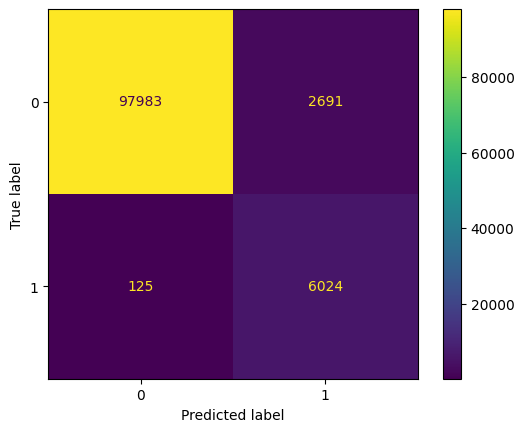

In [ ]:
cm = metrics.confusion_matrix(train_labels_aug2, predictions_train_approx)
print(cm)
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

In [ ]:
saved_model = model.save("/Users/giacomosantoni/Desktop/TESI/Progetto_ML/blindcams/ultima_versione_buoni/tf_model_new/cams_model_new_altering.keras")